In [25]:
from osa_pinn import bbnn, osa_pinn_sdof, normalise
from sdof_oscillators import sdof_solution, add_noise, generate_excitation

import numpy as np
import torch

import time as clock_time

from tqdm import tqdm
from tqdm.auto import tqdm as tqdma

import matplotlib.pyplot as plt
from IPython import display
%matplotlib inline
plt.rcParams.update({
    'text.usetex' : True,
    'mathtext.fontset' : 'stix',
    'font.family' : 'STIXGeneral'
})

%load_ext autoreload
%autoreload 2

def select_alt(data, inds):
    mask = torch.ones_like(data, dtype=torch.bool)
    mask[inds]=False
    return data[mask]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
result_data = torch.load('results/osa_free_linear.pth')
osa_config = result_data['osa_config']

# result_data = {
#     'epoch' : i,
#     'gt_config' : config,
#     'osa_config' : osa_config,
#     'model' : osa_model.state_dict(),
#     'loss' : loss_hist,
#     'ground_truth' : ground_truth,
#     'data' : data,
#     'prediction' : prediction,
#     'alphas' : alphas
# }

In [27]:
nt = 1024
time = np.linspace(0,60,nt)

F0 = 1.0  # N

excitation = {
    "type" : "sinusoid",
    "F0" : F0,
    "w" : 1.6  # rad/s
}

F = generate_excitation(time, **excitation)
excitation["F"] = F.reshape(-1)
### Generate training/ground truth data
m = 10.0
c = 0.75
k = 15.0
excitation["F_tild"] = excitation["F"]/m

wn = np.sqrt(k/m)
zeta = c/(2*m*wn)
wd = wn*np.sqrt(1-zeta**2)

k_tild = k/m
c_tild = c/m

config = {
    "time_" : time,
    "nonlinearity" : "linear",
    "m_norm" : True,
    "params" : {
        "m" : m,
        "k" : k,
        "c" : c,
        "k_tild" : k_tild,
        "c_tild" : c_tild
    },
    "init_conds" : {
        "x0" : 0.01,
        "v0" : 0.05
    },
    "forcing" : None
}

xx, vv = sdof_solution(time, **config)
time = torch.tensor(time).view(-1,1).to(torch.float32)

t_hat_gt, alpha_t = normalise(time, "range")
x_hat_gt, alpha_x = normalise(xx, "range")
v_hat_gt, alpha_v = normalise(vv, "range")

/opt/homebrew/Caskroom/miniforge/base/envs/pytorch2-py310/lib/python3.10/site-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/opt/homebrew/Caskroom/miniforge/base/envs/pytorch2-py310/lib/python3.10/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


Number of estimates in time: 1023
Maximum compute time: 3.9043e-05s
RMSE: 1.1223e-04


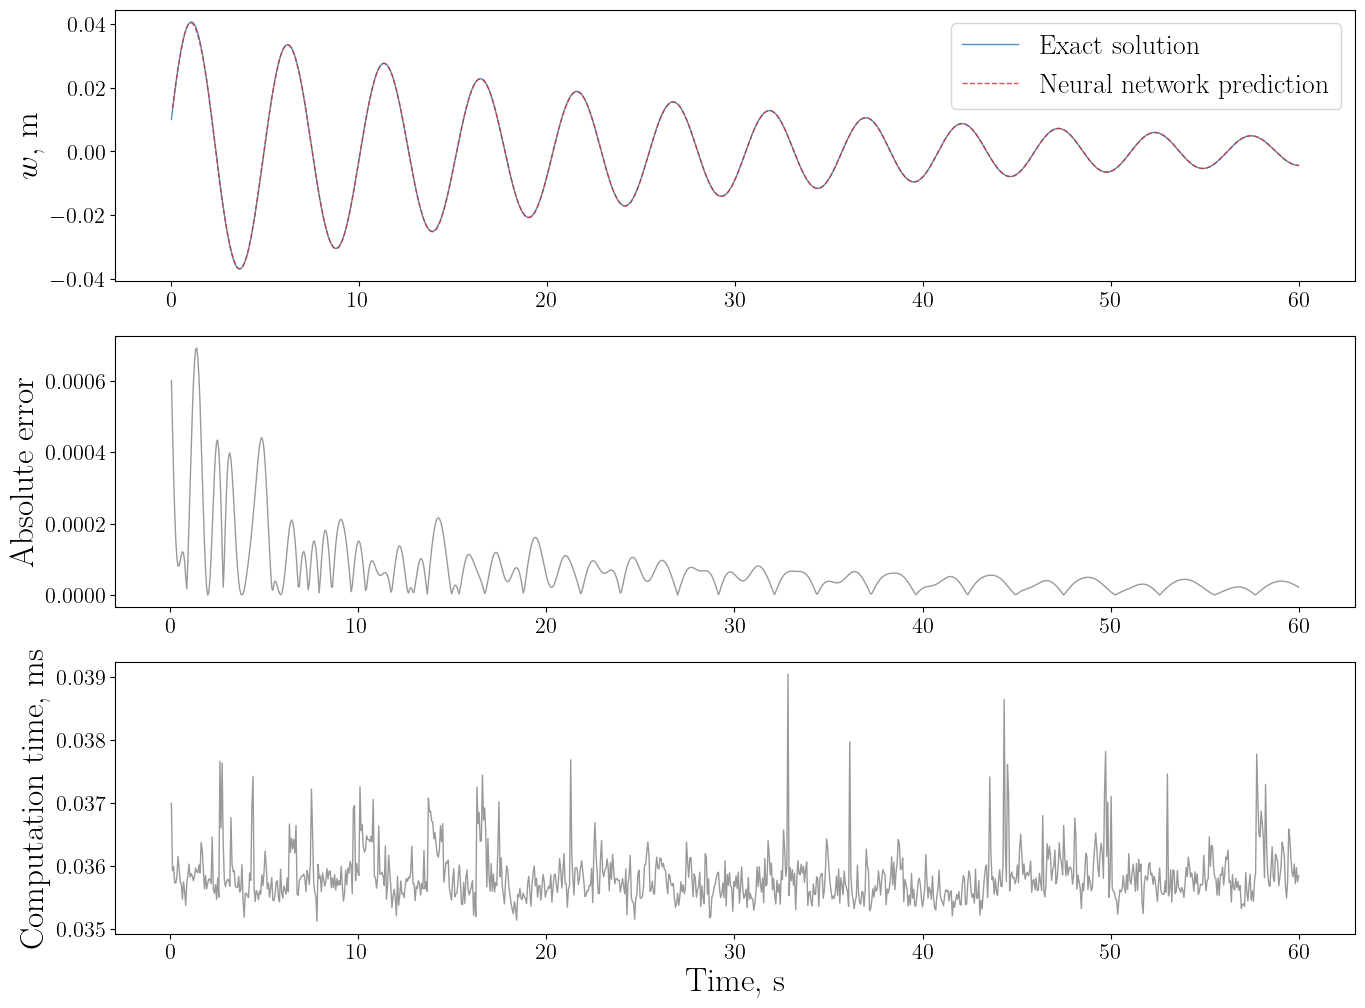

In [28]:
# t_hat_gt = result_data['ground_truth']['t_hat'].squeeze()
# x_hat_gt = result_data['ground_truth']['x_hat'].squeeze()
# v_hat_gt = result_data['ground_truth']['v_hat'].squeeze()

alpha_t = osa_config['alphas']['t']
alpha_x = osa_config['alphas']['x']
alpha_v = osa_config['alphas']['v']

t_test = t_hat_gt[:-1].squeeze()
x0_test = x_hat_gt[:-1].squeeze()
v0_test = v_hat_gt[:-1].squeeze()
# f0_test = F_hat_gt[:-1]
x_obs = x_hat_gt[1:].squeeze()
T_hat = t_hat_gt[1].item() - t_hat_gt[0].item()
T = T_hat * alpha_t

osa_model = osa_pinn_sdof(osa_config)
osa_model.load_state_dict(result_data['model'])

n_test = t_test.shape[0]
err = [0] * n_test
cp_times = [0] * n_test
in_time = [False] * n_test
x_pred = [0] * n_test

cp_times = np.zeros((n_test, 100))

for j in range(100):

    for i in range(n_test):

        x_true = x_obs[i] * alpha_x

        st = clock_time.time()

        x_pred[i] = osa_model.predict_new(x0_test[i], v0_test[i], T_hat).detach() * alpha_x

        et = clock_time.time()

        err[i] = x_pred[i].item() - x_true.item()
        cp_times[i,j] = et - st

        # in_time[i] = cp_times[i] < T

cp_times = np.mean(cp_times, axis=1)
in_time = cp_times < T.item()

fig, axs = plt.subplots(3, 1, figsize=(16,12))
axs[0].plot(time, x_hat_gt*alpha_x, color="tab:blue", linewidth=1, alpha=0.8, label="Exact solution")
axs[0].plot(time[1:], x_pred, color="tab:red", linestyle="--", linewidth=1, alpha=0.8, label="Neural network prediction")
# axs[0].set_xlabel("Time, s", fontsize=24)
axs[0].set_ylabel("$w$, m", fontsize=24)
axs[0].tick_params(axis='both', which='major', labelsize=16)
axs[0].legend(fontsize=20)

axs[1].plot(time[1:], np.abs(err), color="grey", linewidth=1, alpha=0.8)
# axs[1].set_xlabel("Time, s", fontsize=24)
axs[1].set_ylabel("Absolute error", fontsize=24)
axs[1].tick_params(axis='both', which='major', labelsize=16)

axs[2].plot(time[1:], np.array(cp_times)*1e3, color="grey", linewidth=1, alpha=0.8)
axs[2].set_xlabel("Time, s", fontsize=24)
axs[2].set_ylabel("Computation time, ms", fontsize=24)
axs[2].tick_params(axis='both', which='major', labelsize=16)

# axs[0].plot(time[:-1], err)
# # axs[0].set_yscale('log')
# # axs[0].set_ylim((0,10))
# axs[0].plot(time[:-1],x_pred)
# axs[1].plot(cp_times)
# # axs[0].plot(t_data,x_data)
# # axs[1].plot(t_test,x_test)

RMSE = np.sqrt(np.mean(np.array(err)**2))
num_in_time = np.sum(in_time)
max_comp_time = np.max(cp_times)

print("Number of estimates in time: %d\nMaximum compute time: %.4es\nRMSE: %.4e" % (num_in_time, max_comp_time, RMSE))